<a href="https://colab.research.google.com/github/GuraTom9/NLP100/blob/main/NLP100_70_79.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#第8章　ニューラルネットワーク

In [ ]:
%cd "drive/My Drive/NLP100"

/content/drive/My Drive/NLP100


##70. 単語ベクトルの和による特徴量

In [ ]:
! head -15 train.txt

TITLE	CATEGORY
UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection	b
Iraq concerns lift top-rated euro zone bonds but Fed limits gains	b
China Manufacturing Gauge Rises in Stabilization Sign: Economy	b
Crucifixion: A New Way to Think About Jesus' Death	e
Tracy Morgan still critical but 'doing better' following deadly crash which killed his  ...	e
FOREX-Dollar off to slow start in event-packed week	b
Alstom should be a good investment for France, says CEO Kron	b
Diabetes-Related Problems Have Decreased Over Last 20 Years	m
2 Cases Of Ebola Confirmed In Liberia	m
'You Are Not Pregnant. We're Pregnant!' Mila Kunis Tells Off Overeager Fathers  ...	e
Home > Justin Bieber > Justin Bieber Sends Selena Gomez $10k Flowers?	e
Data storage firm Box files for US IPO of about $250 million	b
Cocaine use in U.S. cut in HALF while marijuana use jumps 30 per cent	m
UPDATE 1-HKMA intervenes as deals, China optimism spur Hong Kong dollar  ...	b


In [ ]:
# 学習済み単語ベクトルのロード
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
w2v_model["United_States"]

array([-3.61328125e-02, -4.83398438e-02,  2.35351562e-01,  1.74804688e-01,
       -1.46484375e-01, -7.42187500e-02, -1.01562500e-01, -7.71484375e-02,
        1.09375000e-01, -5.71289062e-02, -1.48437500e-01, -6.00585938e-02,
        1.74804688e-01, -7.71484375e-02,  2.58789062e-02, -7.66601562e-02,
       -3.80859375e-02,  1.35742188e-01,  3.75976562e-02, -4.19921875e-02,
       -3.56445312e-02,  5.34667969e-02,  3.68118286e-04, -1.66992188e-01,
       -1.17187500e-01,  1.41601562e-01, -1.69921875e-01, -6.49414062e-02,
       -1.66992188e-01,  1.00585938e-01,  1.15722656e-01, -2.18750000e-01,
       -9.86328125e-02, -2.56347656e-02,  1.23046875e-01, -3.54003906e-02,
       -1.58203125e-01, -1.60156250e-01,  2.94189453e-02,  8.15429688e-02,
        6.88476562e-02,  1.87500000e-01,  6.49414062e-02,  1.15234375e-01,
       -2.27050781e-02,  3.32031250e-01, -3.27148438e-02,  1.77734375e-01,
       -2.08007812e-01,  4.54101562e-02, -1.23901367e-02,  1.19628906e-01,
        7.44628906e-03, -

In [ ]:
import numpy as np
import torch

def convert_w2v(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()[1:]

    # TITLEテキストを単語ベクトルの平均に変換し、特徴量ベクトルを作成する
    X = []
    for line in lines:
        title = line.split('\t')[0]
        words = title.lower().split()
        vectors = []
        for word in words:
            if word in w2v_model:
                vectors.append(w2v_model[word])
        if len(vectors) > 0:
            X.append(np.mean(vectors, axis=0))
        else:
            X.append(np.zeros(300))
    X = torch.tensor(np.array(X), dtype=torch.float32)

    # CATEGORYをラベルベクトルに変換する
    label_map = {'b': 0, 't': 1, 'e': 2, 'm': 3}
    y = [label_map[line.split('\t')[1].strip()] for line in lines]
    y = torch.tensor(np.array(y))

    return X, y


In [ ]:
X_train, y_train = convert_w2v("train.txt")
X_valid, y_valid = convert_w2v("valid.txt")
X_test, y_test = convert_w2v("test.txt")

print(X_train.shape, y_train.shape)
print(X_train, y_train)

torch.Size([10684, 300]) torch.Size([10684])
tensor([[ 0.0164,  0.0535, -0.0564,  ..., -0.0336,  0.0207, -0.0029],
        [-0.0299,  0.0188,  0.0214,  ..., -0.0400,  0.0317, -0.1316],
        [-0.0130,  0.0603, -0.0431,  ..., -0.0025,  0.1400, -0.1038],
        ...,
        [-0.0905, -0.0079,  0.0337,  ..., -0.0858, -0.0237,  0.0873],
        [-0.0168, -0.0563, -0.1477,  ...,  0.0164,  0.0597,  0.0108],
        [-0.0312, -0.0396, -0.0067,  ...,  0.0805,  0.0866,  0.0168]]) tensor([0, 0, 0,  ..., 2, 0, 0])


##71. 単層ニューラルネットワークによる予測

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SLPNet, self).__init__()
        self.fc1 = nn.Linear(input_size, output_size)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0) # 重みの初期値を設定（平均mean, 標準偏差stdの正規分布）

    def forward(self, x):
        x = self.fc1(x)
        return x


In [ ]:
# モデルのインスタンス化
model = SLPNet(300, 4)
print(model)

SLPNet(
  (fc1): Linear(in_features=300, out_features=4, bias=True)
)


In [ ]:
y1_hat = F.softmax(model(X_train[:1]), dim=1)
print(y1_hat)

Y_hat = F.softmax(model(X_train[:4]), dim=1)
print(Y_hat)

tensor([[0.1180, 0.1532, 0.4810, 0.2478]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1180, 0.1532, 0.4810, 0.2478],
        [0.0334, 0.1213, 0.8397, 0.0055],
        [0.3574, 0.4493, 0.1907, 0.0026],
        [0.0182, 0.4488, 0.4671, 0.0659]], grad_fn=<SoftmaxBackward0>)


##72. 損失と勾配の計算

In [ ]:
# パラメータの確認
for name, param in model.named_parameters():
    print(f'name={name} size={list(param.size())} ({param.numel()}) {param.requires_grad}')

name=fc1.weight size=[4, 300] (1200) True
name=fc1.bias size=[4] (4) True


In [ ]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

In [ ]:
loss1 = criterion(model(X_train[:1]), y_train[:1]) # 損失の計算
print("損失: ", loss1)
model.zero_grad() # 勾配の初期化
loss1.backward() # 勾配の計算
print("勾配: ", model.fc1.weight.grad) # パラメータweightのgrad属性を取得

loss = criterion(model(X_train[:4]), y_train[:4])
print("損失: ", loss)
model.zero_grad()
loss.backward()
print("勾配: ", model.fc1.weight.grad)

損失:  tensor(3.0277, grad_fn=<NllLossBackward0>)
勾配:  tensor([[-1.5579e-02, -5.0955e-02,  5.3704e-02,  ...,  3.1992e-02,
         -1.9650e-02,  2.7878e-03],
        [ 1.9690e-03,  6.4403e-03, -6.7877e-03,  ..., -4.0435e-03,
          2.4836e-03, -3.5236e-04],
        [ 1.3519e-02,  4.4218e-02, -4.6604e-02,  ..., -2.7763e-02,
          1.7052e-02, -2.4192e-03],
        [ 9.0581e-05,  2.9628e-04, -3.1226e-04,  ..., -1.8602e-04,
          1.1426e-04, -1.6210e-05]])
損失:  tensor(1.7486, grad_fn=<NllLossBackward0>)
勾配:  tensor([[ 0.0125, -0.0230,  0.0360,  ...,  0.0187, -0.0372,  0.0458],
        [-0.0031,  0.0122, -0.0037,  ..., -0.0047,  0.0230, -0.0264],
        [-0.0093,  0.0095, -0.0331,  ..., -0.0135,  0.0121, -0.0163],
        [-0.0001,  0.0013,  0.0008,  ..., -0.0005,  0.0021, -0.0031]])


##73. 確率的勾配降下法による学習

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 10

# モデルのインスタンス化
model = SLPNet(300, 4)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 学習
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        inputs = X_train[i]
        labels = y_train[i]

        # 勾配の初期化
        optimizer.zero_grad()

        # 順伝播、損失計算、逆伝播、パラメータ更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 損失の表示
    print('Epoch %d: Loss=%.4f' % (epoch+1, running_loss))

# モデルの保存
torch.save(model.state_dict(), 'SLPNet.model')

Epoch 1: Loss=6014.1058
Epoch 2: Loss=4390.2714
Epoch 3: Loss=4067.7259
Epoch 4: Loss=3896.4385
Epoch 5: Loss=3785.8262
Epoch 6: Loss=3707.2033
Epoch 7: Loss=3648.0493
Epoch 8: Loss=3601.8411
Epoch 9: Loss=3564.7717
Epoch 10: Loss=3534.4338


##74. 正解率の計測

In [ ]:
# モデルの読み込み
model.load_state_dict(torch.load('SLPNet.model'))

<All keys matched successfully>

In [ ]:
# 推論結果の正解率を計算
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, X, y):
    model.eval()
    with torch.no_grad():
        preds = []
        for i in range(len(X)):
            outputs = model(X[i])
            preds.append(torch.argmax(outputs, -1))

        accuracy = accuracy_score(preds, y)
        return accuracy

print('Accuracy(Train): %.4f' % calculate_accuracy(model, X_train, y_train))
print('Accuracy(Valid): %.4f' % calculate_accuracy(model, X_valid, y_valid))

Accuracy(Train): 0.8889
Accuracy(Valid): 0.8780


##75. 損失と正解率のプロット

In [ ]:
# 推論結果の損失を計算
def calculate_loss(model, X, y):
    model.eval()
    with torch.no_grad():
        loss = 0
        for i in range(len(X)):
            outputs = model(X[i])
            loss += criterion(outputs, y[i])
        return loss / len(X)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 10

# モデルのインスタンス化
model = SLPNet(300, 4)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 学習
model.train()
train_loss_log = []
train_acc_log = []
valid_loss_log = []
valid_acc_log = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        inputs = X_train[i]
        labels = y_train[i]

        # 勾配の初期化
        optimizer.zero_grad()

        # 順伝播、損失計算、逆伝播、パラメータ更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 損失の計算
    loss_train = calculate_loss(model, X_train, y_train)
    loss_valid = calculate_loss(model, X_valid, y_valid)

    # 正解率の計算
    acc_train = calculate_accuracy(model, X_train, y_train)
    acc_valid = calculate_accuracy(model, X_valid, y_valid)

    print('Epoch %d: Loss(Train)=%.4f ACC(Train)=%.4f,  Loss(Valid)=%.4f ACC(Valid)=%.4f' % (epoch+1, loss_train, acc_train, loss_valid, acc_valid))

    # ログの取得
    train_loss_log.append(loss_train)
    train_acc_log.append(acc_train)
    valid_loss_log.append(loss_valid)
    valid_acc_log.append(acc_valid)

Epoch 1: Loss(Train)=0.4295 ACC(Train)=0.8493,  Loss(Valid)=0.4397 ACC(Valid)=0.8421
Epoch 2: Loss(Train)=0.3820 ACC(Train)=0.8675,  Loss(Valid)=0.4006 ACC(Valid)=0.8615
Epoch 3: Loss(Train)=0.3600 ACC(Train)=0.8764,  Loss(Valid)=0.3855 ACC(Valid)=0.8735
Epoch 4: Loss(Train)=0.3469 ACC(Train)=0.8792,  Loss(Valid)=0.3777 ACC(Valid)=0.8750
Epoch 5: Loss(Train)=0.3382 ACC(Train)=0.8830,  Loss(Valid)=0.3730 ACC(Valid)=0.8765
Epoch 6: Loss(Train)=0.3319 ACC(Train)=0.8852,  Loss(Valid)=0.3700 ACC(Valid)=0.8780
Epoch 7: Loss(Train)=0.3271 ACC(Train)=0.8864,  Loss(Valid)=0.3680 ACC(Valid)=0.8802
Epoch 8: Loss(Train)=0.3234 ACC(Train)=0.8882,  Loss(Valid)=0.3668 ACC(Valid)=0.8780
Epoch 9: Loss(Train)=0.3205 ACC(Train)=0.8892,  Loss(Valid)=0.3660 ACC(Valid)=0.8772
Epoch 10: Loss(Train)=0.3180 ACC(Train)=0.8900,  Loss(Valid)=0.3655 ACC(Valid)=0.8772


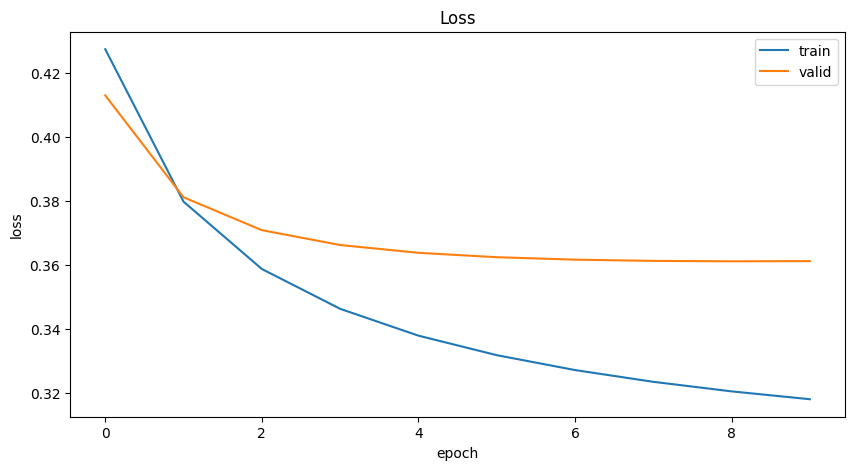

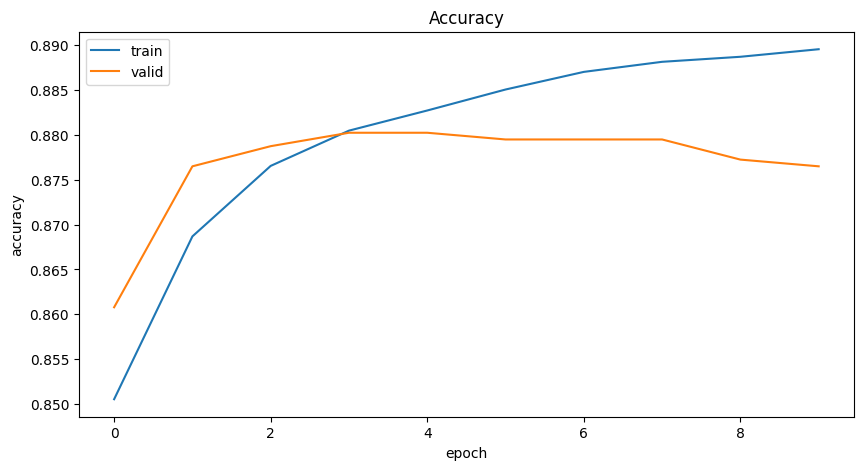

In [ ]:
import matplotlib.pyplot as plt

# lossのグラフ
plt.figure(figsize=(10, 5))
plt.plot(train_loss_log, label='train')
plt.plot(valid_loss_log, label='valid')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# accuracyのグラフ
plt.figure(figsize=(10, 5))
plt.plot(train_acc_log, label='train')
plt.plot(valid_acc_log, label='valid')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


##76. チェックポイント

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

checkpoint_dir = './checkpoints'  # チェックポイントを保存するディレクトリ
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 10

# モデルのインスタンス化
model = SLPNet(300, 4)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 学習
model.train()
train_loss_log = []
train_acc_log = []
valid_loss_log = []
valid_acc_log = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        inputs = X_train[i]
        labels = y_train[i]

        # 勾配の初期化
        optimizer.zero_grad()

        # 順伝播、損失計算、逆伝播、パラメータ更新
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 損失の計算
    loss_train = calculate_loss(model, X_train, y_train)
    loss_valid = calculate_loss(model, X_valid, y_valid)

    # 正解率の計算
    acc_train = calculate_accuracy(model, X_train, y_train)
    acc_valid = calculate_accuracy(model, X_valid, y_valid)

    print('Epoch %d: Loss(Train)=%.4f ACC(Train)=%.4f,  Loss(Valid)=%.4f ACC(Valid)=%.4f' % (epoch+1, loss_train, acc_train, loss_valid, acc_valid))

    # ログの取得
    train_loss_log.append(loss_train)
    train_acc_log.append(acc_train)
    valid_loss_log.append(loss_valid)
    valid_acc_log.append(acc_valid)

    # チェックポイントの保存
    checkpoint = {'epoch': epoch,
                   'model_state_dict': model.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict()}
    checkpoint_path = os.path.join(checkpoint_dir, f"Epoch{epoch+1}.cpt")
    torch.save(checkpoint, checkpoint_path)

Epoch 1: Loss(Train)=0.4243 ACC(Train)=0.8502,  Loss(Valid)=0.4184 ACC(Valid)=0.8518
Epoch 2: Loss(Train)=0.3785 ACC(Train)=0.8698,  Loss(Valid)=0.3850 ACC(Valid)=0.8645
Epoch 3: Loss(Train)=0.3583 ACC(Train)=0.8769,  Loss(Valid)=0.3739 ACC(Valid)=0.8698
Epoch 4: Loss(Train)=0.3464 ACC(Train)=0.8811,  Loss(Valid)=0.3687 ACC(Valid)=0.8743
Epoch 5: Loss(Train)=0.3383 ACC(Train)=0.8830,  Loss(Valid)=0.3657 ACC(Valid)=0.8765
Epoch 6: Loss(Train)=0.3323 ACC(Train)=0.8846,  Loss(Valid)=0.3640 ACC(Valid)=0.8787
Epoch 7: Loss(Train)=0.3278 ACC(Train)=0.8868,  Loss(Valid)=0.3630 ACC(Valid)=0.8787
Epoch 8: Loss(Train)=0.3242 ACC(Train)=0.8883,  Loss(Valid)=0.3624 ACC(Valid)=0.8780
Epoch 9: Loss(Train)=0.3213 ACC(Train)=0.8893,  Loss(Valid)=0.3621 ACC(Valid)=0.8757
Epoch 10: Loss(Train)=0.3188 ACC(Train)=0.8902,  Loss(Valid)=0.3621 ACC(Valid)=0.8743


##77. ミニバッチ化

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# データセットの作成
dataset_train = TensorDataset(X_train, y_train)
dataset_valid = TensorDataset(X_valid, y_valid)
dataset_test = TensorDataset(X_test, y_test)

print(vars(dataset_train))

{'tensors': (tensor([[ 0.0164,  0.0535, -0.0564,  ..., -0.0336,  0.0207, -0.0029],
        [-0.0299,  0.0188,  0.0214,  ..., -0.0400,  0.0317, -0.1316],
        [-0.0130,  0.0603, -0.0431,  ..., -0.0025,  0.1400, -0.1038],
        ...,
        [-0.0905, -0.0079,  0.0337,  ..., -0.0858, -0.0237,  0.0873],
        [-0.0168, -0.0563, -0.1477,  ...,  0.0164,  0.0597,  0.0108],
        [-0.0312, -0.0396, -0.0067,  ...,  0.0805,  0.0866,  0.0168]]), tensor([0, 0, 0,  ..., 2, 0, 0]))}


In [ ]:
# 推論結果の正解率を計算(DataLoader用に改良)
from sklearn.metrics import accuracy_score

def calculate_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        correct = 0
        num_data = 0
        for inputs, labels in dataloader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, -1)
            num_data += len(inputs)
            correct += (preds == labels).sum().item()
        accuracy = correct / num_data
        return accuracy

# 推論結果の損失を計算(DataLoader用に改良)
def calculate_loss(model, dataloader):
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
        return loss / len(dataloader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time

checkpoint_dir = './checkpoints'  # チェックポイントを保存するディレクトリ
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 1

# モデルのインスタンス化
model = SLPNet(300, 4)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

def train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid):
    # データローダーの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    # 学習
    model.train()
    train_loss_log = []
    train_acc_log = []
    valid_loss_log = []
    valid_acc_log = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        running_loss = 0.0
        for inputs, labels in dataloader_train:
            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播、損失計算、逆伝播、パラメータ更新
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 損失の計算
        loss_train = calculate_loss(model, dataloader_train)
        loss_valid = calculate_loss(model, dataloader_valid)

        # 正解率の計算
        acc_train = calculate_accuracy(model, dataloader_train)
        acc_valid = calculate_accuracy(model, dataloader_valid)

        # ログの取得
        train_loss_log.append(loss_train)
        train_acc_log.append(acc_train)
        valid_loss_log.append(loss_valid)
        valid_acc_log.append(acc_valid)

        # チェックポイントの保存
        checkpoint = {'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}
        checkpoint_path = os.path.join(checkpoint_dir, f"Epoch{epoch+1}.cpt")
        torch.save(checkpoint, checkpoint_path)

        # 終了時刻の記録
        e_time = time.time()

        print('---Batch Size: %d---' % batch_size)
        print('Epoch %d (%.4f sec): Loss(Train)=%.4f ACC(Train)=%.4f,  Loss(Valid)=%.4f ACC(Valid)=%.4f' % (epoch+1, e_time-s_time, loss_train, acc_train, loss_valid, acc_valid))


In [ ]:
batch_size_list = [2**i for i in range(10)]
for batch_size in batch_size_list:
    train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid)

---Batch Size: 1---
Epoch 1 (7.1673 sec): Loss(Train)=0.4289 ACC(Train)=0.8519,  Loss(Valid)=0.4194 ACC(Valid)=0.8555
---Batch Size: 2---
Epoch 1 (5.0835 sec): Loss(Train)=0.3998 ACC(Train)=0.8610,  Loss(Valid)=0.3967 ACC(Valid)=0.8615
---Batch Size: 4---
Epoch 1 (2.2144 sec): Loss(Train)=0.3871 ACC(Train)=0.8686,  Loss(Valid)=0.3864 ACC(Valid)=0.8645
---Batch Size: 8---
Epoch 1 (1.2590 sec): Loss(Train)=0.3829 ACC(Train)=0.8699,  Loss(Valid)=0.3830 ACC(Valid)=0.8668
---Batch Size: 16---
Epoch 1 (0.8048 sec): Loss(Train)=0.3811 ACC(Train)=0.8711,  Loss(Valid)=0.3804 ACC(Valid)=0.8675
---Batch Size: 32---
Epoch 1 (0.5479 sec): Loss(Train)=0.3797 ACC(Train)=0.8710,  Loss(Valid)=0.3808 ACC(Valid)=0.8675
---Batch Size: 64---
Epoch 1 (0.4196 sec): Loss(Train)=0.3792 ACC(Train)=0.8707,  Loss(Valid)=0.3805 ACC(Valid)=0.8675
---Batch Size: 128---
Epoch 1 (0.3313 sec): Loss(Train)=0.3781 ACC(Train)=0.8709,  Loss(Valid)=0.3772 ACC(Valid)=0.8668
---Batch Size: 256---
Epoch 1 (0.3081 sec): Loss(Tr

##78. GPU上での学習

In [ ]:
# 推論結果の正解率を計算(GPU用に改良)
def calculate_accuracy(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        num_data = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, -1)
            num_data += len(inputs)
            correct += (preds == labels).sum().item()
        accuracy = correct / num_data
        return accuracy

# 推論結果の損失を計算(GPU用に改良)
def calculate_loss(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
        return loss / len(dataloader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time

# GPUが使用可能な場合は、deviceをGPUに設定する
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = './checkpoints'  # チェックポイントを保存するディレクトリ
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 1

# モデルのインスタンス化
model = SLPNet(300, 4).to(device)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

def train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid):
    # データローダーの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    # 学習
    model.train()
    train_loss_log = []
    train_acc_log = []
    valid_loss_log = []
    valid_acc_log = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        running_loss = 0.0
        for inputs, labels in dataloader_train:
            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播、損失計算、逆伝播、パラメータ更新
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 損失の計算
        loss_train = calculate_loss(model, dataloader_train, device=device)
        loss_valid = calculate_loss(model, dataloader_valid, device=device)

        # 正解率の計算
        acc_train = calculate_accuracy(model, dataloader_train, device=device)
        acc_valid = calculate_accuracy(model, dataloader_valid, device=device)

        # ログの取得
        train_loss_log.append(loss_train)
        train_acc_log.append(acc_train)
        valid_loss_log.append(loss_valid)
        valid_acc_log.append(acc_valid)

        # チェックポイントの保存
        checkpoint = {'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}
        checkpoint_path = os.path.join(checkpoint_dir, f"Epoch{epoch+1}.cpt")
        torch.save(checkpoint, checkpoint_path)

        # 終了時刻の記録
        e_time = time.time()

        print('Batch Size %d (%.4f sec): Loss(Train)=%.4f ACC(Train)=%.4f,  Loss(Valid)=%.4f ACC(Valid)=%.4f' % (batch_size, e_time-s_time, loss_train, acc_train, loss_valid, acc_valid))


In [ ]:
batch_size_list = [2**i for i in range(10)]
for batch_size in batch_size_list:
    train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid)

Batch Size 1 (18.8170 sec): Loss(Train)=0.4220 ACC(Train)=0.8541,  Loss(Valid)=0.4231 ACC(Valid)=0.8555
Batch Size 2 (7.7361 sec): Loss(Train)=0.3929 ACC(Train)=0.8631,  Loss(Valid)=0.3981 ACC(Valid)=0.8623
Batch Size 4 (4.6225 sec): Loss(Train)=0.3824 ACC(Train)=0.8688,  Loss(Valid)=0.3887 ACC(Valid)=0.8593
Batch Size 8 (2.1554 sec): Loss(Train)=0.3769 ACC(Train)=0.8714,  Loss(Valid)=0.3857 ACC(Valid)=0.8600
Batch Size 16 (1.1798 sec): Loss(Train)=0.3748 ACC(Train)=0.8714,  Loss(Valid)=0.3824 ACC(Valid)=0.8660
Batch Size 32 (0.7458 sec): Loss(Train)=0.3736 ACC(Train)=0.8722,  Loss(Valid)=0.3828 ACC(Valid)=0.8668
Batch Size 64 (0.4613 sec): Loss(Train)=0.3732 ACC(Train)=0.8723,  Loss(Valid)=0.3826 ACC(Valid)=0.8668
Batch Size 128 (0.3409 sec): Loss(Train)=0.3738 ACC(Train)=0.8725,  Loss(Valid)=0.3793 ACC(Valid)=0.8660
Batch Size 256 (0.5094 sec): Loss(Train)=0.3729 ACC(Train)=0.8723,  Loss(Valid)=0.3736 ACC(Valid)=0.8668
Batch Size 512 (0.2551 sec): Loss(Train)=0.3729 ACC(Train)=0.8723

##79. 多層ニューラルネットワーク

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPNet(nn.Module):
    def __init__(self, input_size, middle_size, output_size):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(input_size, middle_size)
        self.fc2 = nn.Linear(middle_size, middle_size)
        self.out = nn.Linear(middle_size, output_size)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm1d(middle_size)

    def forward(self, x):
        x = self.dropout(F.relu(self.batch_norm(self.fc1(x))))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.out(x))
        return x

In [ ]:
# 推論結果の正解率を計算(GPU用に改良)
def calculate_accuracy(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        num_data = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, -1)
            num_data += len(inputs)
            correct += (preds == labels).sum().item()
        accuracy = correct / num_data
        return accuracy

# 推論結果の損失を計算(GPU用に改良)
def calculate_loss(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        loss = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
        return loss / len(dataloader)

In [ ]:
def linear_combination(x, y, epsilon):
    return (1 - epsilon) * x + epsilon * y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction

    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(nll, loss/n, self.epsilon)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time

# GPUが使用可能な場合は、deviceをGPUに設定する
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint_dir = './checkpoints'  # チェックポイントを保存するディレクトリ
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# ハイパーパラメータの設定
lr = 0.1
num_epochs = 30

# モデルのインスタンス化
model = MLPNet(300, 200, 4).to(device)

# 損失関数とオプティマイザの定義
#criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(model.parameters(), lr=lr)

def train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid):
    # データローダーの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    # スケジューラの設定
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

    # 学習
    model.train()
    train_loss_log = []
    train_acc_log = []
    valid_loss_log = []
    valid_acc_log = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()

        running_loss = 0.0
        for inputs, labels in dataloader_train:
            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播、損失計算、逆伝播、パラメータ更新
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # 損失の計算
        loss_train = calculate_loss(model, dataloader_train, device=device)
        loss_valid = calculate_loss(model, dataloader_valid, device=device)

        # 正解率の計算
        acc_train = calculate_accuracy(model, dataloader_train, device=device)
        acc_valid = calculate_accuracy(model, dataloader_valid, device=device)

        # ログの取得
        train_loss_log.append(loss_train)
        train_acc_log.append(acc_train)
        valid_loss_log.append(loss_valid)
        valid_acc_log.append(acc_valid)

        # チェックポイントの保存
        checkpoint = {'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()}
        checkpoint_path = os.path.join(checkpoint_dir, f"Epoch{epoch+1}.cpt")
        torch.save(checkpoint, checkpoint_path)

        # 終了時刻の記録
        e_time = time.time()

        scheduler.step()

        print('Epoch %d (%.4f sec): Loss(Train)=%.4f ACC(Train)=%.4f,  Loss(Valid)=%.4f ACC(Valid)=%.4f' % (epoch+1, e_time-s_time, loss_train, acc_train, loss_valid, acc_valid))


In [ ]:
batch_size = 64
train_model(num_epochs, batch_size, model, criterion, optimizer, dataset_train, dataset_valid)

Epoch 1 (0.8215 sec): Loss(Train)=0.6817 ACC(Train)=0.8525,  Loss(Valid)=0.6828 ACC(Valid)=0.8488
Epoch 2 (0.8339 sec): Loss(Train)=0.6683 ACC(Train)=0.8485,  Loss(Valid)=0.6762 ACC(Valid)=0.8510
Epoch 3 (0.7920 sec): Loss(Train)=0.5759 ACC(Train)=0.8884,  Loss(Valid)=0.6040 ACC(Valid)=0.8757
Epoch 4 (1.0162 sec): Loss(Train)=0.6018 ACC(Train)=0.8748,  Loss(Valid)=0.6448 ACC(Valid)=0.8608
Epoch 5 (1.1089 sec): Loss(Train)=0.5658 ACC(Train)=0.8930,  Loss(Valid)=0.6177 ACC(Valid)=0.8645
Epoch 6 (1.0816 sec): Loss(Train)=0.5901 ACC(Train)=0.8885,  Loss(Valid)=0.6431 ACC(Valid)=0.8593
Epoch 7 (1.0020 sec): Loss(Train)=0.5254 ACC(Train)=0.9235,  Loss(Valid)=0.5969 ACC(Valid)=0.8862
Epoch 8 (0.8108 sec): Loss(Train)=0.4994 ACC(Train)=0.9272,  Loss(Valid)=0.5913 ACC(Valid)=0.8907
Epoch 9 (0.7926 sec): Loss(Train)=0.5177 ACC(Train)=0.9218,  Loss(Valid)=0.6185 ACC(Valid)=0.8757
Epoch 10 (0.8018 sec): Loss(Train)=0.4751 ACC(Train)=0.9444,  Loss(Valid)=0.5888 ACC(Valid)=0.8877
Epoch 11 (0.8060 se